In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize  import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy , CategoricalCrossentropy

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [172]:
happy = pd.read_csv("C:/Users/abhi7/wordbag.csv")
sad = pd.read_csv("C:/Users/abhi7/Desktop/Twitter_Data.csv")

In [173]:
print(happy.columns)
print(sad.columns)

Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


In [174]:
df = pd.concat([happy,sad]).drop_duplicates(subset = 'text').reset_index(drop=True)

df = df.drop([],axis=1)
df.head(10)

,text,label
0,Happy birthday big bro,1.0
1,Happy birthday Shimika Brown ❣️🎁🎊🎉,1.0
2,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...,1.0
3,oooooo ya girl is so happy rn https://t.co/kcG...,1.0
4,@WillieGeist sweet castle br0. happy bday,1.0
5,Happy Valley hero puts basketball world in a s...,1.0
6,@offl_Lawrence I wish very happy birthday mom....,1.0
7,@mariportsa happy birthday queen 🙈,1.0
8,Happy Interpreter Day @toniterp. SEBI apprecia...,1.0
9,new music i’m so happy,1.0


In [175]:
df['label'].mask(df['label'] == -1,'negative',  inplace=True)
df['label'].mask(df['label'] == 0,'normal',  inplace=True)
df['label'].mask(df['label'] == 1,'positive',  inplace=True)
df.head()

,text,label
0,Happy birthday big bro,positive
1,Happy birthday Shimika Brown ❣️🎁🎊🎉,positive
2,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...,positive
3,oooooo ya girl is so happy rn https://t.co/kcG...,positive
4,@WillieGeist sweet castle br0. happy bday,positive


In [176]:
# Distribution of different classes
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])
count_values_in_column(df,"label")

,Total,Percentage
label,,
positive,84880,44.55
normal,55210,28.97
negative,50450,26.48
NaN,7,0.00


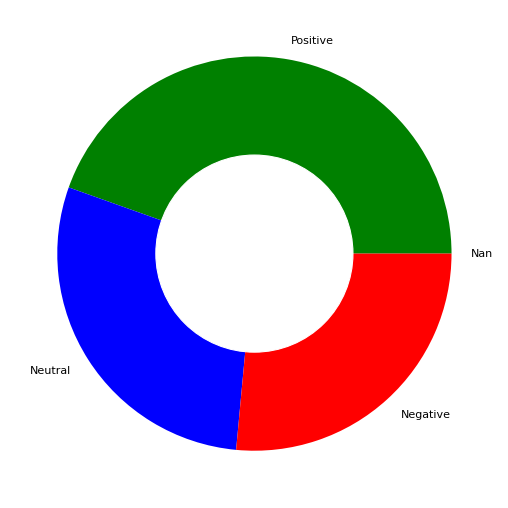

In [177]:
# create data for Pie Chart
plt.figure(figsize=(13, 8), dpi=80)
pichart = count_values_in_column(df,"label")
names= ["Positive","Neutral","Negative","Nan"]
size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['green','blue','red',"yellow"])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190547 entries, 0 to 190546
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    190546 non-null  object
 1   label   190540 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [179]:
df.label.unique()

array(['positive', 'negative', 'normal', nan], dtype=object)

In [180]:
df.isna().sum()


text     1
label    7
dtype: int64

In [181]:
df= df.dropna()

In [182]:
df.duplicated().sum()

0

In [183]:
df['label'].value_counts()

label
positive    84879
normal      55210
negative    50450
Name: count, dtype: int64

In [184]:
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [185]:
df['Tidy'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

df.head(10)

,text,label,Tidy
0,Happy birthday big bro,positive,Happy birthday big bro
1,Happy birthday Shimika Brown ❣️🎁🎊🎉,positive,Happy birthday Shimika Brown ❣️🎁🎊🎉
2,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...,positive,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...
3,oooooo ya girl is so happy rn https://t.co/kcG...,positive,oooooo ya girl is so happy rn https://t.co/kcG...
4,@WillieGeist sweet castle br0. happy bday,positive,sweet castle br0. happy bday
5,Happy Valley hero puts basketball world in a s...,positive,Happy Valley hero puts basketball world in a s...
6,@offl_Lawrence I wish very happy birthday mom....,positive,I wish very happy birthday mom......
7,@mariportsa happy birthday queen 🙈,positive,happy birthday queen 🙈
8,Happy Interpreter Day @toniterp. SEBI apprecia...,positive,Happy Interpreter Day . SEBI appreciates all y...
9,new music i’m so happy,positive,new music i’m so happy


In [186]:
#REMOVE STOPWORDS
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english')
df['Tidy'] = df['Tidy'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_english)]))

df.head(10)

,text,label,Tidy
0,Happy birthday big bro,positive,Happy birthday big bro
1,Happy birthday Shimika Brown ❣️🎁🎊🎉,positive,Happy birthday Shimika Brown ❣️🎁🎊🎉
2,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...,positive,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...
3,oooooo ya girl is so happy rn https://t.co/kcG...,positive,oooooo ya girl happy rn https://t.co/kcGXJQLtab
4,@WillieGeist sweet castle br0. happy bday,positive,sweet castle br0. happy bday
5,Happy Valley hero puts basketball world in a s...,positive,Happy Valley hero puts basketball world spin h...
6,@offl_Lawrence I wish very happy birthday mom....,positive,I wish happy birthday mom......
7,@mariportsa happy birthday queen 🙈,positive,happy birthday queen 🙈
8,Happy Interpreter Day @toniterp. SEBI apprecia...,positive,Happy Interpreter Day . SEBI appreciates
9,new music i’m so happy,positive,new music i’m happy


In [187]:
#REMOVE EMOJIS FROM THE DATASET
import re
import emoji
def remove_emojis(text):
    # Remove emojis using a regular expression
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'', text)
    
    return cleaned_text
df['Tidy'] = df['Tidy'].apply(remove_emojis)
df.head(10)

,text,label,Tidy
0,Happy birthday big bro,positive,Happy birthday big bro
1,Happy birthday Shimika Brown ❣️🎁🎊🎉,positive,Happy birthday Shimika Brown
2,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...,positive,Happy Birthday!!! My son!!#MamaBendecida https...
3,oooooo ya girl is so happy rn https://t.co/kcG...,positive,oooooo ya girl happy rn https://t.co/kcGXJQLtab
4,@WillieGeist sweet castle br0. happy bday,positive,sweet castle br0. happy bday
5,Happy Valley hero puts basketball world in a s...,positive,Happy Valley hero puts basketball world spin h...
6,@offl_Lawrence I wish very happy birthday mom....,positive,I wish happy birthday mom......
7,@mariportsa happy birthday queen 🙈,positive,happy birthday queen
8,Happy Interpreter Day @toniterp. SEBI apprecia...,positive,Happy Interpreter Day . SEBI appreciates
9,new music i’m so happy,positive,new music i’m happy


In [188]:
#REMOVE lINKS FROM THE DATASET
def remove_https_links(text):
    return re.sub(r'https:\/\/\S+', '', text)

# Apply the function to the 'TextColumn'
df['Tidy'] = df['Tidy'].apply(remove_https_links)
df.head(10)

,text,label,Tidy
0,Happy birthday big bro,positive,Happy birthday big bro
1,Happy birthday Shimika Brown ❣️🎁🎊🎉,positive,Happy birthday Shimika Brown
2,Happy Birthday!!!🎂🎈 My son!!😍#MamaBendecida🙏 h...,positive,Happy Birthday!!! My son!!#MamaBendecida
3,oooooo ya girl is so happy rn https://t.co/kcG...,positive,oooooo ya girl happy rn
4,@WillieGeist sweet castle br0. happy bday,positive,sweet castle br0. happy bday
5,Happy Valley hero puts basketball world in a s...,positive,Happy Valley hero puts basketball world spin
6,@offl_Lawrence I wish very happy birthday mom....,positive,I wish happy birthday mom......
7,@mariportsa happy birthday queen 🙈,positive,happy birthday queen
8,Happy Interpreter Day @toniterp. SEBI apprecia...,positive,Happy Interpreter Day . SEBI appreciates
9,new music i’m so happy,positive,new music i’m happy


In [189]:
def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

In [190]:
ht_positive = Hashtags_Extract(df['Tidy'][df['label']=='positive'])

ht_positive

[[],
 [],
 ['MamaBendecida'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['MakeAMetallicaSongSofter'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['NAME'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['cebiday'],
 [],
 [],
 [],
 [],
 ['fifththirdbank'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['EXONTHEBEACH'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['WeNeedMoreRaisa', 'Arrow'],
 [],
 [],
 ['TheBigBangTheory'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['boxing', 'GGGvanes'],
 [],
 [],
 ['inners'],
 [],
 ['Scandal', 'SummerGladiators'],
 [],
 ['34thMainesary'],
 [],
 [],
 [],
 ['HBDSouthQueenTrisha'],
 ['Seventeen1stWin'],
 [],
 [],
 ['PremiumBritishBeer', 'IronMaiden'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['heartsforchristina'],
 [],
 [],
 [],
 ['keepsmiling', 'keeprocking'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []

In [191]:
ht_positive_unnest = sum(ht_positive,[])

In [192]:
ht_negative = Hashtags_Extract(df['Tidy'][df['label']=='negative'])

ht_negative

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['mets'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['MATIA'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['MAGA'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['sad'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['DemocratsHateAmerica'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['nomorehighschool'],
 [],
 [],
 [],
 [],
 ['InfinityWar'],
 [],
 [],
 [],
 ['FridayFeeling', 'sad', 'sadness', 'unhappy', 'time'],
 [],
 ['MAGA', 'sad'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []

In [193]:
ht_negative_unnest = sum(ht_negative,[])

In [194]:
import nltk
word_freq_positive = nltk.FreqDist(ht_positive_unnest)

word_freq_positive

FreqDist({'StarWarsDay': 50, 'MayThe4thBeWithYou': 45, 'Supernatural': 42, 'MayTheFourthBeWithYou': 26, '34thMainesary': 20, 'GreysAnatomy': 19, 'happy': 15, 'DragRace': 12, 'supernatural': 11, 'WorldPressFreedomDay': 11, ...})

In [195]:
df_positive = pd.DataFrame({'Hashtags':list(word_freq_positive.keys()),'Count':list(word_freq_positive.values())})

df_positive.head(10)

,Hashtags,Count
0,MamaBendecida,1
1,MakeAMetallicaSongSofter,7
2,NAME,1
3,cebiday,9
4,fifththirdbank,1
5,EXONTHEBEACH,1
6,WeNeedMoreRaisa,1
7,Arrow,4
8,TheBigBangTheory,1
9,boxing,1


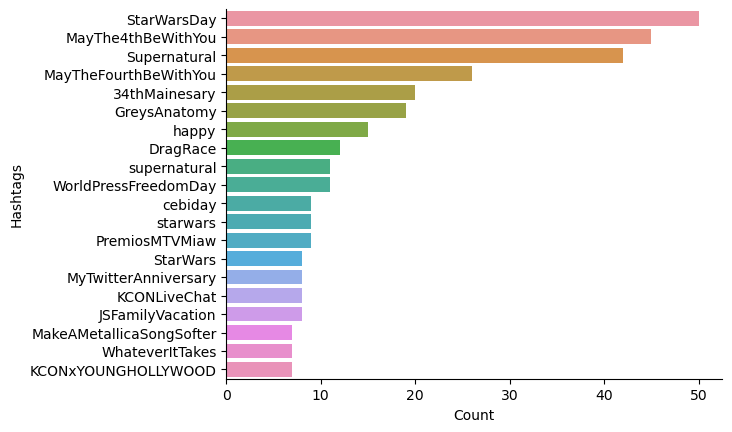

In [143]:

df_positive_plot = df_positive.nlargest(20,columns='Count')

sns.barplot(data=df_positive_plot,y='Hashtags',x='Count')
sns.despine()

In [196]:
word_freq_negative = nltk.FreqDist(ht_negative_unnest)

word_freq_negative

FreqDist({'sad': 46, 'Mets': 22, 'Sad': 15, 'Corrie': 12, 'InfinityWar': 10, 'RoarForChange': 9, 'SAD': 8, 'BHAMUN': 8, 'MUFC': 7, 'NRA': 7, ...})

In [197]:
df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})

df_negative.head(10)

,Hashtags,Count
0,mets,6
1,MATIA,1
2,MAGA,5
3,sad,46
4,DemocratsHateAmerica,1
5,nomorehighschool,1
6,InfinityWar,10
7,FridayFeeling,4
8,sadness,1
9,unhappy,1


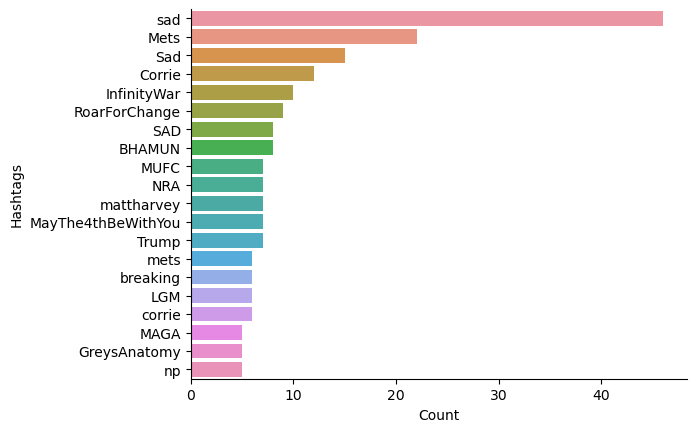

In [198]:

df_negative_plot = df_negative.nlargest(20,columns='Count') 

sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()

In [199]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tidy'])
df['Tidy'] = tokenizer.texts_to_sequences(df['Tidy'])
df['Tidy']

0                                         [7, 82, 113, 702]
1                                      [7, 82, 46854, 6792]
2                                  [7, 82, 818, 726, 46855]
3                               [20710, 2773, 903, 7, 3091]
4                             [2378, 17252, 46856, 7, 1467]
                                ...                        
190542    [5510, 435, 513, 2549, 1, 2825, 8, 152, 214, 1...
190543    [242, 316, 482, 14166, 11071, 1, 1140, 1746, 1...
190544                              [1564, 2591, 7618, 295]
190545            [113, 502, 274, 2, 1, 814, 502, 293, 515]
190546    [166, 553, 5, 40317, 5193, 5942, 20, 9, 1, 316...
Name: Tidy, Length: 190539, dtype: object

In [200]:
df['label'].mask(df['label'] == 'negative',-1,  inplace=True)
df['label'].mask(df['label'] == 'normal',0,  inplace=True)
df['label'].mask(df['label'] == 'positive',1,  inplace=True)
df['label']

0          1
1          1
2          1
3          1
4          1
          ..
190542    -1
190543    -1
190544     0
190545     0
190546     1
Name: label, Length: 190539, dtype: object

In [201]:
X_train, X_test, y_train, y_test = train_test_split(df['Tidy'],df['label'], test_size=0.2, random_state=40)

In [202]:
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 152431
y_train: 152431
X_test: 38108
y_test: 38108


In [203]:
X_train = pad_sequences( X_train, maxlen=100 ,dtype='float32')
X_test = pad_sequences( X_test, maxlen=100 ,dtype='float32')

In [204]:
len(tokenizer.index_word)

125844

In [205]:
model_1 = Sequential()
model_1.add(Embedding(len(tokenizer.index_word)+1, input_length= 100 ,output_dim =50))
model_1.add(Bidirectional(LSTM(100)))
model_1.add(Flatten())
model_1.add(Dense(250, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile("adam", loss= 'binary_crossentropy' ,metrics=["accuracy"])
model_1.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 50)           6292250   
                                                                 
 bidirectional_7 (Bidirecti  (None, 200)               120800    
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 250)               50250     
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 251       
                                                      

In [206]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [207]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [78]:
history_1 = model_1.fit(X_train , y_train ,batch_size=64, epochs=7,
                    validation_data=(X_test , y_test),callbacks=[early_stop])

Epoch 1/7
2382/2382 [==============================] - 775s 320ms/step - loss: -3285.1853 - accuracy: 0.4046 - val_loss: -15954.9941 - val_accuracy: 0.4924
Epoch 2/7
2382/2382 [==============================] - 709s 298ms/step - loss: -45782.4023 - accuracy: 0.5149 - val_loss: -86446.1094 - val_accuracy: 0.5609
Epoch 3/7
2382/2382 [==============================] - 710s 298ms/step - loss: -150654.6250 - accuracy: 0.5509 - val_loss: -214133.2656 - val_accuracy: 0.5520
Epoch 4/7
2382/2382 [==============================] - 696s 292ms/step - loss: -328060.8750 - accuracy: 0.5676 - val_loss: -344611.5312 - val_accuracy: 0.5362
Epoch 5/7
2382/2382 [==============================] - 706s 297ms/step - loss: -588437.1250 - accuracy: 0.5808 - val_loss: -649795.3750 - val_accuracy: 0.5668
Epoch 6/7
2382/2382 [==============================] - 744s 313ms/step - loss: -916596.1875 - accuracy: 0.5919 - val_loss: -952678.8125 - val_accuracy: 0.5799
Epoch 7/7
2382/2382 [==============================

In [79]:

model_1.save_weights('model_1_weights.h5')
model_1.save('full_model_1.h5')

In [208]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [209]:
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, input_length= 100 ,output_dim =100))
model.add(LSTM(100))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile("adam", loss= 'categorical_crossentropy' ,metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          12584500  
                                                                 
 lstm_10 (LSTM)              (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 128)               12928     
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 12678215 (48.36 MB)
Trainable params: 12678215 (48.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
history = model.fit(X_train , y_train ,batch_size=256, epochs=4,
                    validation_data=(X_test , y_test),callbacks=[early_stop])

Epoch 1/4
596/596 [==============================] - 387s 629ms/step - loss: 0.4092 - accuracy: 0.8442 - val_loss: 0.2821 - val_accuracy: 0.9122
Epoch 2/4
596/596 [==============================] - 375s 629ms/step - loss: 0.2041 - accuracy: 0.9366 - val_loss: 0.2824 - val_accuracy: 0.9135
Epoch 3/4
596/596 [==============================] - 370s 621ms/step - loss: 0.1497 - accuracy: 0.9535 - val_loss: 0.3107 - val_accuracy: 0.9079
Epoch 4/4
596/596 [==============================] - 347s 582ms/step - loss: 0.1100 - accuracy: 0.9649 - val_loss: 0.3348 - val_accuracy: 0.9036


In [83]:
model.save_weights('model_weights.h5')
model.save('full_model.h5')

In [210]:
model_1.load_weights('model_1_weights.h5')

In [211]:
model.load_weights('model_weights.h5')

In [212]:
results = model.evaluate(X_test, y_test, batch_size=64)


596/596 [==============================] - 49s 76ms/step - loss: 0.3348 - accuracy: 0.9036


In [214]:
from sklearn.metrics import f1_score

# Assuming model.evaluate returns a tuple with (loss, accuracy)
loss, accuracy = model.evaluate(X_test, y_test, batch_size=256)

# Assuming model.predict returns the predicted probabilities
y_pred_prob = (model.predict(X_test))

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Flatten y_test if it's in multilabel-indicator format
y_test_flat = y_test.argmax(axis=1) if len(y_test.shape) > 1 else y_test

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='micro')

# print(classification_report(f'Loss: {loss}\n Accuracy: {accuracy}\n F1 Score: {f1}'))
print(classification_report(y_test, y_pred))

1191/1191 [==============================] - 54s 45ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     10966
           1       0.84      0.94      0.89     17054
           2       0.66      0.93      0.77     10088

   micro avg       0.80      0.94      0.87     38108
   macro avg       0.80      0.94      0.86     38108
weighted avg       0.81      0.94      0.87     38108
 samples avg       0.86      0.94      0.88     38108



In [164]:
#BiLSTM + CNN
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Embedding, Conv1D,MaxPooling1D, Bidirectional, LSTM, Dense

In [165]:
y_train_label_encoded = pd.DataFrame(y_train).idxmax(axis=1).values
y_test_label_encoded = pd.DataFrame(y_test).idxmax(axis=1).values

In [166]:
embed_dim = 128
lstm_out = 196

model2 = Sequential()
model2.add(Embedding(len(tokenizer.index_word)+1, embed_dim,input_length = 100))
model2.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='Nadam',metrics = ['accuracy'])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 128)          16108160  
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 256)          98560     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 256)           0         
 g1D)                                                            
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 3)                 771       
                                                                 
Total params: 16601731 (63.33 MB)
Trainable params: 16

In [112]:
batch_size =  64
epoch = 7
test_acc_bilstmcnn = []
train_acc_bilstmcnn = []
for i in range(epoch):
    model2.fit(X_train, y_train, epochs = 1, batch_size=batch_size, verbose = 1)
    Y_test_pred =np.argmax(model2.predict(X_test), axis=-1)
    test_acc_bilstmcnn.append(accuracy_score(y_test_label_encoded,Y_test_pred))
    
    Y_train_pred =np.argmax(model2.predict(X_train), axis=-1)
    train_acc_bilstmcnn.append(accuracy_score(y_train_label_encoded,Y_train_pred))

4764/4764 [==============================] - 102s 21ms/step


In [113]:
model2.save_weights('model2_weights.h5')
model2.save('full_model2.h5')

In [167]:
model2.load_weights('model2_weights.h5')

In [168]:
Y_pred =np.argmax(model2.predict(X_test), axis=-1)

1191/1191 [==============================] - 70s 56ms/step


In [170]:
print(classification_report(y_test_label_encoded,Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     10966
           1       0.89      0.90      0.89     17054
           2       0.83      0.86      0.84     10088

    accuracy                           0.88     38108
   macro avg       0.88      0.88      0.88     38108
weighted avg       0.88      0.88      0.88     38108

